In [1]:
import numpy as np
import random
import math

import glob
from   PIL import Image

import matplotlib.pyplot as plt

In [2]:
def get_images_from_folder(folder):
    images = []

    for filename in glob.glob(f'data/{folder}/*.jpg') + glob.glob(f'data/{folder}/*.png'):
        im = Image.open(filename)
        im = np.array(im).astype(np.float32) / 255
        images.append(im)

    return images

In [3]:
def get_chunk_from_image(image, size):
    chunk = image[random.randint(0, image.shape[0] - size):, 
                  random.randint(0, image.shape[1] - size):]
    chunk = chunk[:size, :size]
    return chunk

In [4]:
def pixellate(image, chunk_size = 5):
    w, h, c = image.shape
    s       = chunk_size

    pixel_map = image.reshape(w//s, s, h//s, s, c)
    pixel_map = pixel_map.transpose(0,2,1,3,4)

    pixel_map = np.average(pixel_map, axis = (2,3,4))
    return pixel_map

In [5]:
# https://stackoverflow.com/questions/2197020/create-grid-out-of-number-of-elements

def plot_image_grid(images):

    x = math.floor(math.sqrt(len(images)))
    y = math.ceil(len(images) / x)

    f, axarr = plt.subplots(y, x)

    for i in range(x * y):

        im_x = math.floor(i / x)
        im_y = i % x

        axarr[im_x, im_y].axis('off')

        if (i < len(images)): axarr[im_x, im_y].imshow(images[i])

    plt.show()

In [6]:
def difference(a, b):
    return 1 - np.abs(a - b)

In [7]:
class SampleGenerator:
    def __init__(self, sample_shape):
        self.sample_shape = sample_shape

    def get_sample(self):
        return np.zeros(self.sample_shape)

In [8]:
class FloatSampleGenerator(SampleGenerator):
    def __init__(self, sample_shape=[], minval=0, maxval=1):
        self.sample_shape = sample_shape
        self.minval       = minval
        self.maxval       = maxval

    def get_sample(self):
        return np.random.uniform(self.minval, self.maxval, self.sample_shape)

In [9]:
class ConvolutionalSampleGenerator(SampleGenerator):
    def __init__(self, folder = None, images = None, sample_size = 5):
        self.sample_size  = sample_size
        self.sample_shape = [sample_size, sample_size, 3]

        if (folder is not None):
            self.images = get_images_from_folder(folder)
        elif images is not None:
            self.images = images
        else:
            raise(Exception('Must provide either folder path or image list'))
        
    def get_sample(self):
        image = random.choice(self.images)
        return get_chunk_from_image(image, self.sample_size)

In [10]:
class PatternMatcher:
    def __init__(self, num_patterns, pattern_initializer, comparison_fn = difference):
        self.num_patterns     = num_patterns
        self.sample_generator = pattern_initializer
        self.pattern_shape    = pattern_initializer.sample_shape

        self.patterns         = np.array([pattern_initializer.get_sample() for i in range(num_patterns)])
        self.examples_seen    = np.ones([self.num_patterns])

        self.comparison_fn    = comparison_fn

    def train_sample(self, sample = None, learning_rate = 'auto'):
        sample = sample or self.sample_generator.get_sample()

        most_similar   = self.get_most_similar(sample)
        chosen_pattern = self.patterns[most_similar]
        
        if (learning_rate == 'auto'): learning_rate = 1 / (self.examples_seen[most_similar]+1)
        
        self.patterns[most_similar] = chosen_pattern * (1 - learning_rate) + sample * learning_rate
        self.examples_seen[most_similar] += 1

    def get_most_similar(self, sample):
        return np.argmax(self.get_similarity_scores(sample))

    def get_similarity_scores(self, sample):
        return np.average(self.comparison_fn(self.patterns, sample), axis=list(range(1, len(self.pattern_shape)+1)))
    
    def get_activation_map(self, image):
        if (len(self.pattern_shape) != 3):
            raise Exception(f"This function only available with a 3D pattern shape, this shape: {self.pattern_shape}")
        
        w,h,c = image.shape
        x_tiles = int(math.floor(w / self.pattern_shape[0]))-1
        y_tiles = int(math.floor(h / self.pattern_shape[1]))-1

        activation_map = np.zeros([self.num_patterns,
                                   w-self.pattern_shape[0]+1,
                                   h-self.pattern_shape[1]+1])

        # per-pattern for now
        for i, pattern in enumerate(self.patterns):
            tiled = np.tile(pattern, [x_tiles, y_tiles, 1])

            max_x = w - tiled.shape[0] + 1
            max_y = h - tiled.shape[1] + 1

            for x in range(0, max_x):
                for y in range(0, max_y):
                    padded = np.pad(tiled, [[x, max_x - x - 1],[y, max_y - y - 1],[0,0]])

                    subbed = self.comparison_fn(padded, image)
                    subbed = subbed[x:tiled.shape[0] + x, y:tiled.shape[1] + y]
                    subbed = pixellate(subbed, chunk_size=self.pattern_shape[0])
                    
                    activation_map[i, 
                                   x:x + tiled.shape[0]:self.pattern_shape[0], 
                                   y:y + tiled.shape[1]:self.pattern_shape[1]] = subbed
                    
        return activation_map

    # separation should be easy
    # divergence

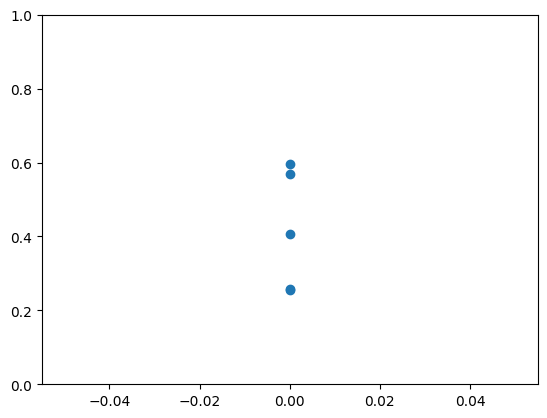

In [11]:
# Create a basic float PatternMatcher and see
# its original patterns

s = FloatSampleGenerator()
p = PatternMatcher(5, s)

plt.ylim(0, 1)
plt.scatter(np.zeros([5]), list(sorted(p.patterns)))
plt.show()

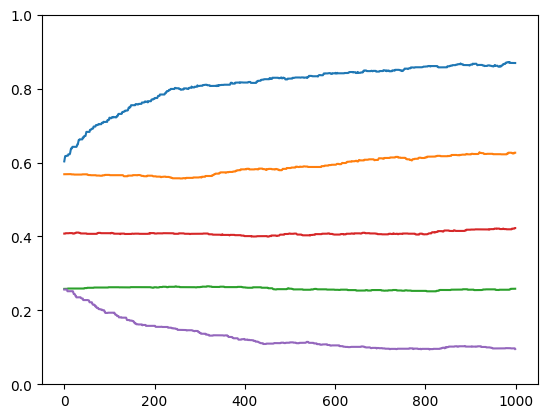

In [12]:
# Plot the PatternMatcher learning floats
# Notice how the patterns diverge to get the best separation

history = []

for i in range(1000):
    p.train_sample(learning_rate = 1/50)
    history.append(list(p.patterns))

plt.ylim(0, 1)
plt.plot(history)
plt.show()

In [13]:
# Create a more complicated image PatternMatcher and see
# its original patterns

cs = ConvolutionalSampleGenerator('cats')
cp = PatternMatcher(16, cs)

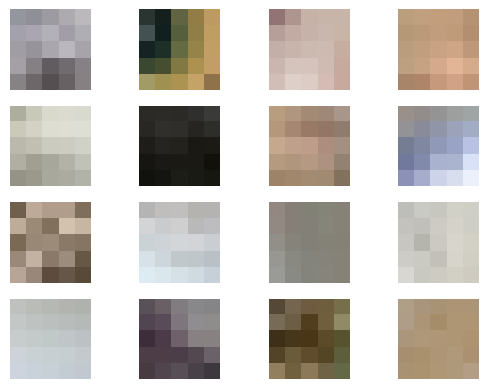

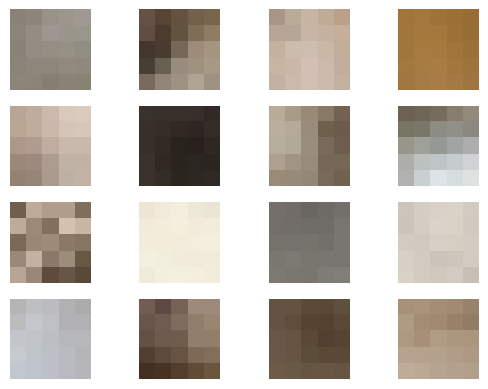

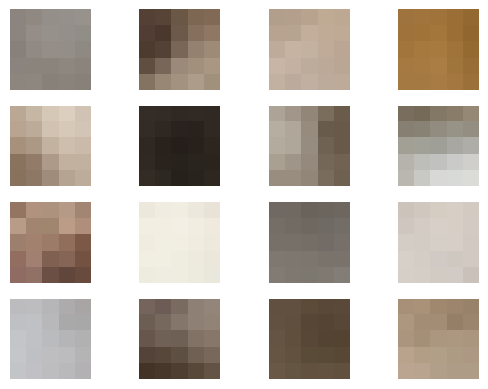

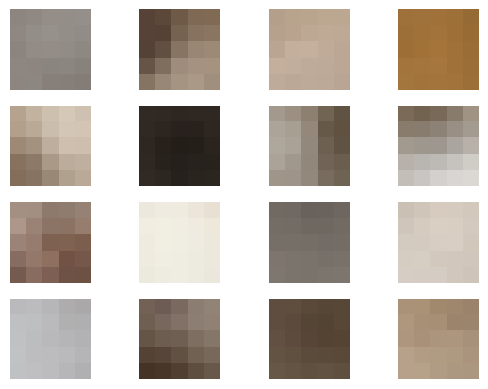

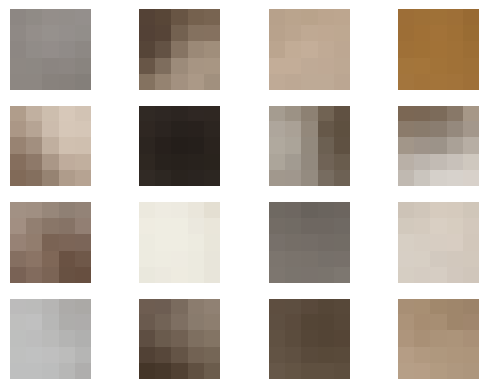

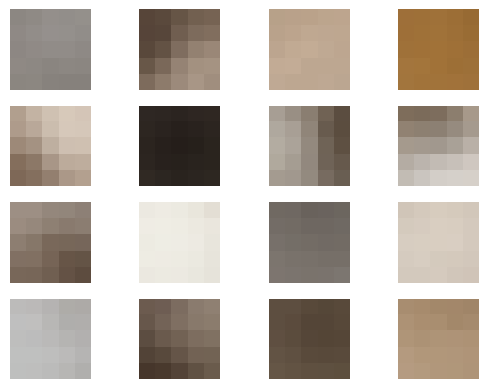

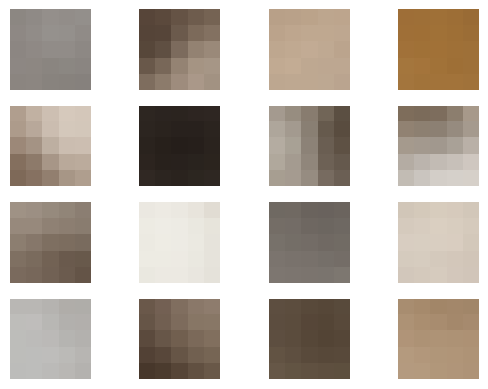

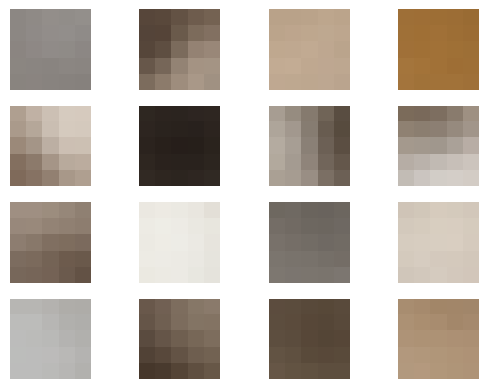

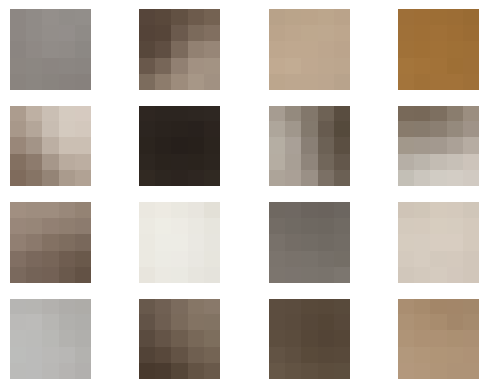

In [14]:
# Train and watch the patterns diverge

plot_image_grid(cp.patterns)

for j in range(8):
    for i in range(250):
        cp.train_sample()
    plot_image_grid(cp.patterns)

In [15]:
# Create a larger image PatternMatcher and see
# its original patterns

cs = ConvolutionalSampleGenerator('cats', sample_size=11)
cp = PatternMatcher(16, cs)

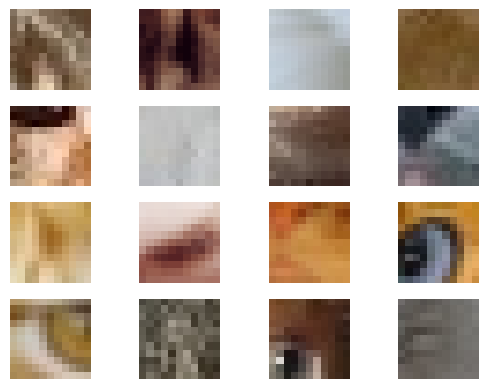

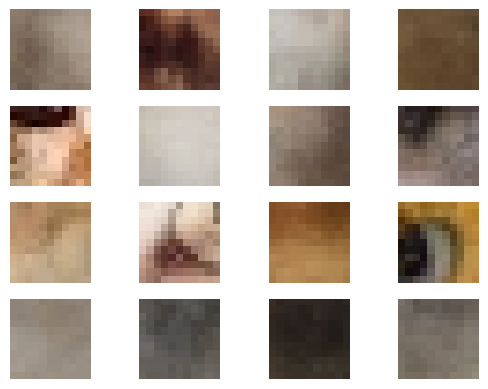

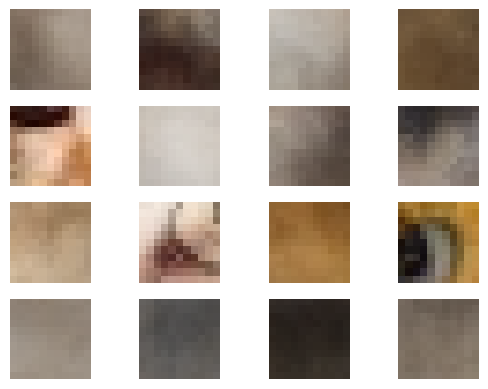

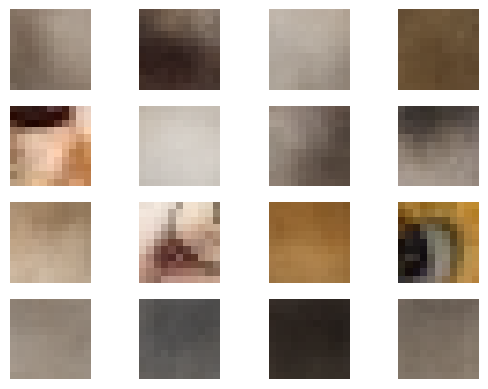

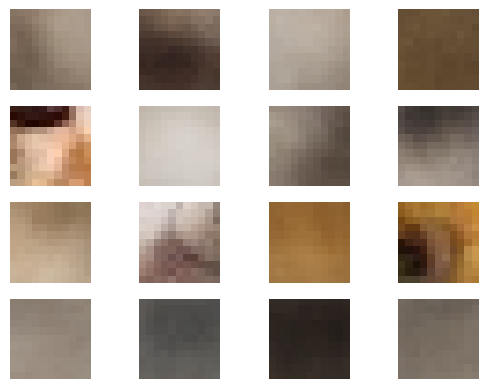

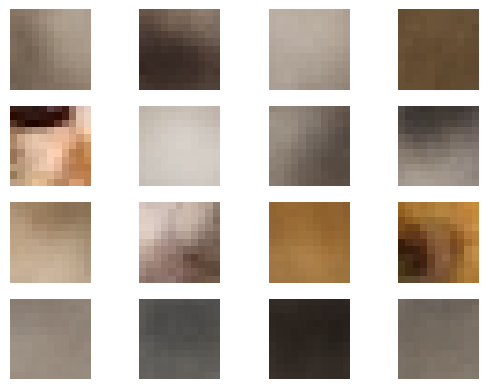

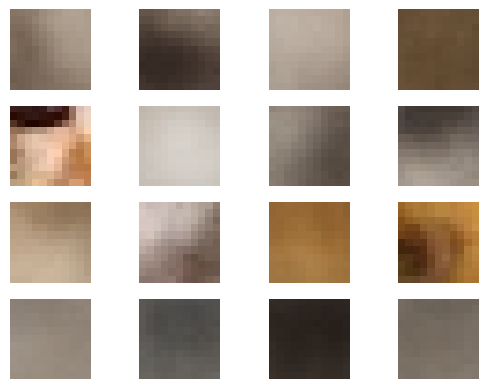

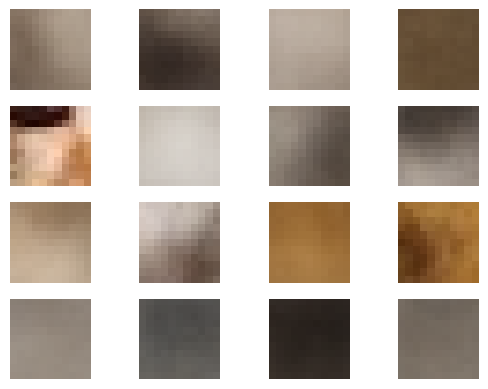

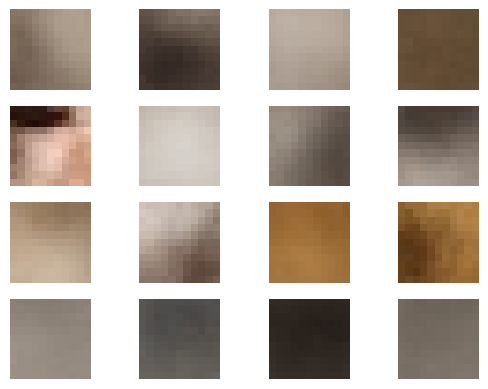

In [16]:
# Train and watch the patterns diverge

plot_image_grid(cp.patterns)

for j in range(8):
    for i in range(250):
        cp.train_sample()
    plot_image_grid(cp.patterns)

In [17]:
# Create a number PatternMatcher and see
# its original patterns

cs = ConvolutionalSampleGenerator('numbers', sample_size=5)
cp = PatternMatcher(8, cs)

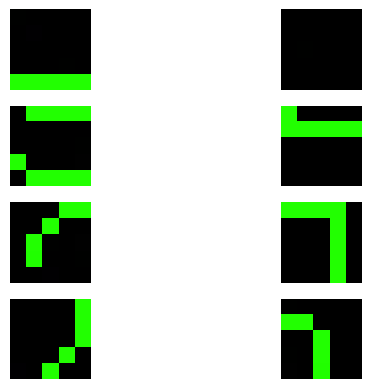

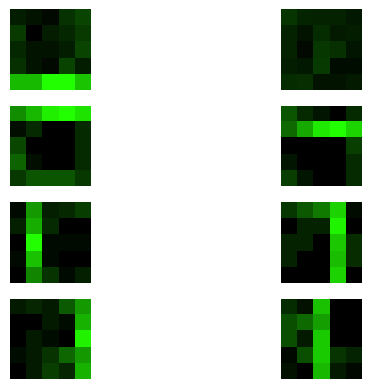

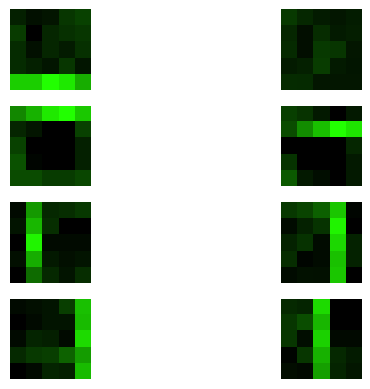

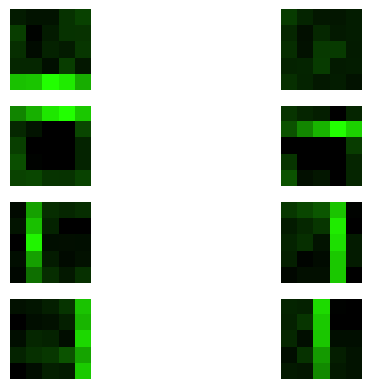

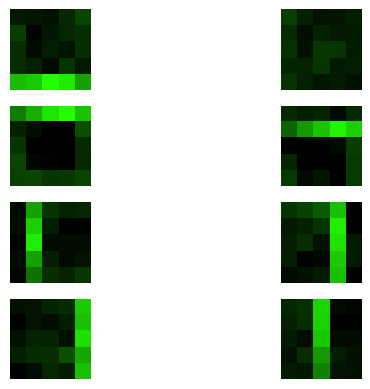

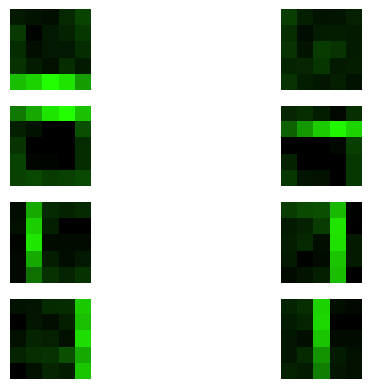

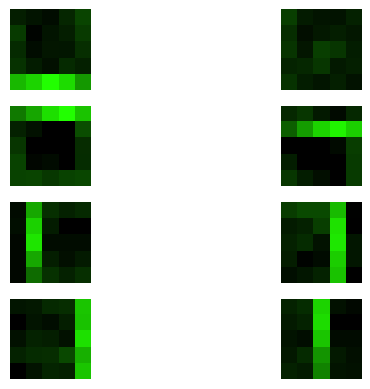

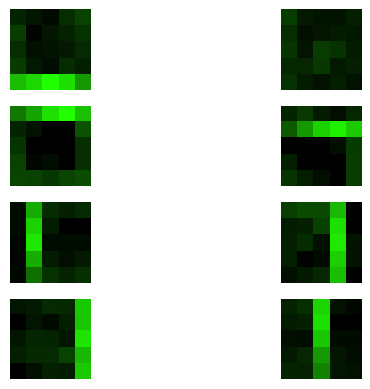

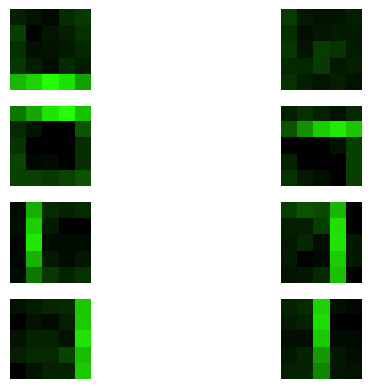

In [18]:
# Train and watch the patterns diverge

plot_image_grid(cp.patterns)

for j in range(8):
    for i in range(250):
        cp.train_sample()
    plot_image_grid(cp.patterns)

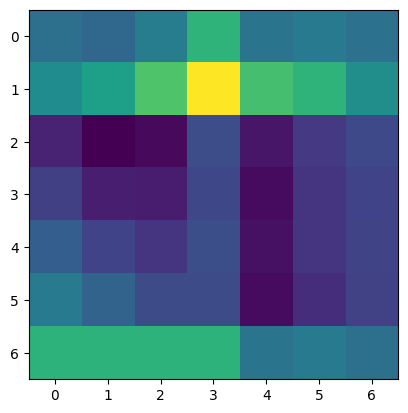

In [19]:
a = cp.get_activation_map(cs.images[0])
plt.imshow(a[0])